# Cats vs Dogs

In this tutorial, we're going to train our classifier to distinguish pictures of cats and dogs. The dataset were are going to work with was published in this [challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition).

### Setup
* Download the preprocessed training data from [here](https://drive.google.com/file/d/0BwaX_s62pOTnbDY4VklDRVRjSDQ/view?usp=sharing).
* Extract and place it in the following directory: **data/cats_v_dogs_preprocessed**.
* Install **matplotlib** using conda or other Python package manager.

In [1]:
import os, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Data preparation
Simply load the preprocessed data.

In [2]:
DATA_DIR = "data/cats_v_dogs_preprocessed"

WIDTH = 64
HEIGHT = 64
CHANNELS = 3
PIXEL_DEPTH = 255

train_data = np.load(os.path.join(DATA_DIR, "train_data.npy"))
train_labels = np.load(os.path.join(DATA_DIR, "train_labels.npy"))

valid_data = np.load(os.path.join(DATA_DIR, "valid_data.npy"))
valid_labels = np.load(os.path.join(DATA_DIR, "valid_labels.npy"))

train_norm = np.load(os.path.join(DATA_DIR, "train_norm.npy"))
valid_norm = np.load(os.path.join(DATA_DIR, "valid_norm.npy"))

In [4]:
class Dataset():
    
    def __init__(self, train_data, train_labels, valid_data, valid_labels, batch_size=50):
        self.train_data = train_data
        self.train_labels = train_labels
        self.valid_data = valid_data
        self.valid_labels = valid_labels
        
        self.i = 0
        self.batch_size = batch_size
        self.size = self.train_data.shape[0]
        
    def get_batch(self):
        
        ind = range(self.i, self.i + self.batch_size)
        
        data = self.train_data.take(ind, axis=0, mode="wrap")
        labels = self.train_labels.take(ind, axis=0, mode="wrap")
        
        self.i = (self.i + self.batch_size) % self.size
        
        return data, labels
    
    def get_valid_data(self):
        return self.valid_data, self.valid_labels
    
dset = Dataset(train_norm, train_labels, valid_norm, valid_labels)

A few examples:


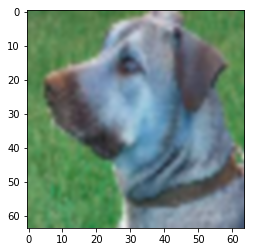

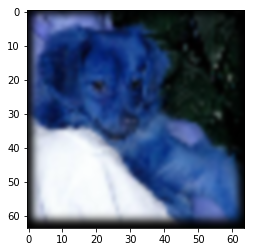

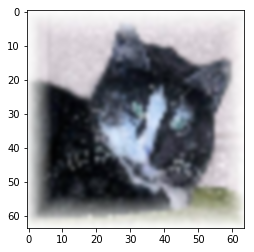

In [10]:
print("A few examples:")

for i in range(3):
    plt.imshow(train_data[i].astype(np.uint8), interpolation="bicubic")
    plt.show()

### Defining our network

We're going to define and train a simple convolutional neural network. The network should train for about 2 minutes and achieve about 70% accuracy on the validation dataset.

In [7]:
tf.reset_default_graph()

input_layer = tf.placeholder(tf.float32, shape=(None, WIDTH, HEIGHT, CHANNELS))
one_hot_labels = tf.placeholder(tf.int64, shape=(None, 2))

conv1 = tf.layers.conv2d(input_layer, 16, (5, 5), padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(conv1, (2, 2), 2)

conv2 = tf.layers.conv2d(pool1, 32, (5, 5), padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(conv2, (2, 2), 2)

pool2_flat = tf.reshape(pool2, [-1, pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value])
dense = tf.layers.dense(pool2_flat, units=64, activation=tf.nn.relu)

logits = tf.layers.dense(dense, units=2)

predictions = tf.argmax(input=logits, axis=1)
labels_argmax = tf.argmax(input=one_hot_labels, axis=1)

correct = tf.equal(predictions, labels_argmax)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels, logits=logits))

tf.summary.scalar("trainig_loss", loss)
tf.summary.scalar("validation_accuracy", accuracy)

learning_rate = 0.0005
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

In [6]:
def train_step():
    data, labels = dset.get_batch()
                
    tmp_loss, _ = sess.run([loss, train_op], feed_dict = {
        input_layer: data,
        one_hot_labels: labels
    })
    
    return tmp_loss

def valid_step():
    
    valid_data, valid_labels = dset.get_valid_data()
                                    
    tmp_accuracy = sess.run(accuracy, feed_dict = {
        input_layer: valid_data,
        one_hot_labels: valid_labels
    })
 
    return tmp_accuracy

def baseline():
    
    _, valid_labels = dset.get_valid_data()
        
    cats = np.sum(valid_labels[:, 0])
    dogs = np.sum(valid_labels[:, 1])

    if cats >= dogs:
        ratio = cats / (cats + dogs)
        print("always predict cats accuracy: %.2f%%" % (ratio * 100))
    else:
        ratio = dogs / (cats + dogs)
        print("always predict dogs accuracy: %.2f%%" % (ratio * 100))
        
def example_predictions(sess, amount=10):
    data, _ = dset.get_valid_data()

    data = data[:amount]
    labels = sess.run(predictions, feed_dict = {
        input_layer: data
    })
    
    return labels

In [13]:
num_iters = 1000
batch_size = 32
log_frequency = 100

dset.batch_size = batch_size

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init_op)
    
    total_loss = 0
    
    for i in range(num_iters):
        
        if i != 0 and i % log_frequency == 0:
            print("training loss: %f" % (total_loss / log_frequency))
            total_loss = 0
                                                
            tmp_accuracy = valid_step()
            
            print("validation accuracy: %.2f%%" % (tmp_accuracy * 100))
        
        total_loss += train_step()
        
    tmp_accuracy = valid_step()
    print("\nfinal accuracy: %.2f%%" % (tmp_accuracy * 100))
    
    baseline()
    sample_predictions = example_predictions(sess)

training loss: 0.658730
validation accuracy: 67.50%
training loss: 0.572130
validation accuracy: 66.50%
training loss: 0.492770
validation accuracy: 71.00%
training loss: 0.405754
validation accuracy: 68.00%
training loss: 0.336869
validation accuracy: 67.00%
training loss: 0.273826
validation accuracy: 67.50%
training loss: 0.197386
validation accuracy: 65.00%
training loss: 0.170200
validation accuracy: 73.00%
training loss: 0.231203
validation accuracy: 65.50%

final accuracy: 67.00%
always predict dogs accuracy: 52.50%


prediction: cat


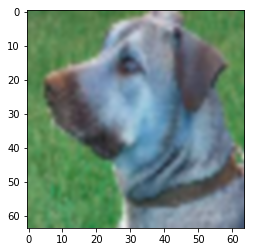

prediction: cat


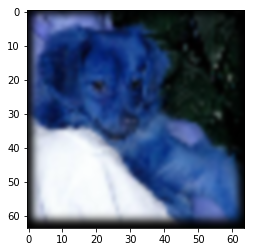

prediction: cat


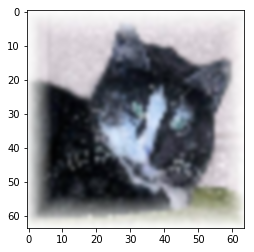

prediction: dog


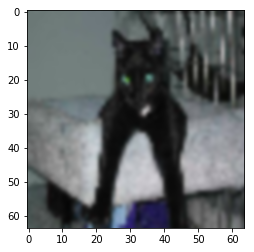

prediction: cat


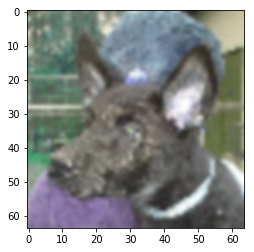

prediction: dog


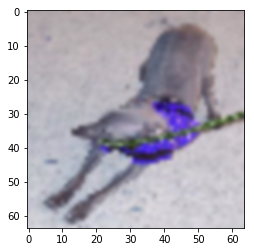

prediction: cat


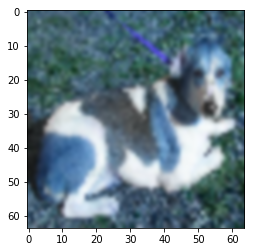

prediction: dog


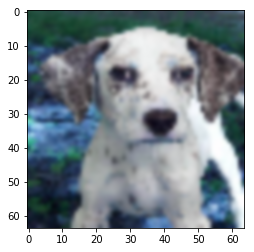

prediction: cat


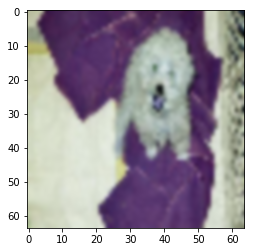

prediction: cat


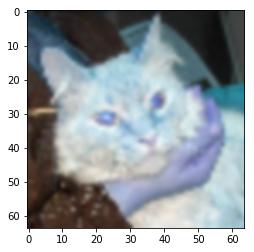

In [14]:
for i in range(10):
    if sample_predictions[i] == 0:
        print("prediction: cat")
    else:
        print("prediction: dog")
        
    plt.imshow(train_data[i].astype(np.uint8), interpolation="bicubic")
    plt.show()

*In an informal poll conducted many years ago, computer vision experts posited that a classifier with better than 60% accuracy would be difficult without a major advance in the state of the art.*

## Task (10 points)
For this graded task, I'd like you to improve the neural network. Since we're using a very limited amount of training data, our convolutional network might be **overfitting**. We can fix this with **dropout**. Dropout is a form of regularization that drops a certain number of activations during training to make the neural network more robust.

1. Implement dropout (10 points). Use the following two links as a reference: [dropout documentation](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [MNIST tutorial (with dropout)](https://www.tensorflow.org/get_started/mnist/pros).

In [ ]:
tf.reset_default_graph()

input_layer = tf.placeholder(tf.float32, shape=(None, WIDTH, HEIGHT, CHANNELS))
one_hot_labels = tf.placeholder(tf.int64, shape=(None, 2))

conv1 = tf.layers.conv2d(input_layer, 16, (5, 5), padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(conv1, (2, 2), 2)

conv2 = tf.layers.conv2d(pool1, 32, (5, 5), padding="same", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(conv2, (2, 2), 2)

pool2_flat = tf.reshape(pool2, [-1, pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value])
dense = tf.layers.dense(pool2_flat, units=64, activation=tf.nn.relu)

"""
TODO: dropout
Add dropout after the dense layer.
You'll need to add a placeholder to control it (drop 0.5 activations during trainign, don't drop any during validation).
"""

logits = tf.layers.dense(dense, units=2)

predictions = tf.argmax(input=logits, axis=1)
labels_argmax = tf.argmax(input=one_hot_labels, axis=1)

correct = tf.equal(predictions, labels_argmax)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_labels, logits=logits))

learning_rate = 0.0005
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)


In [ ]:
def train_step_with_dropout():
    data, labels = dset.get_batch()
                    
    """
    TODO: dropout
    You should activate dropout in the feed dictionary (keep probability = 0.5).
    """
        
    tmp_loss, _ = sess.run([loss, train_op], feed_dict = {
        input_layer: data,
        one_hot_labels: labels
    })
    
    return tmp_loss

def valid_step_without_dropout():
    
    valid_data, valid_labels = dset.get_valid_data()
                       
    """
    TODO: dropout
    You should deactivate dropout feed dictionary (keep probability = 1).
    """
        
    tmp_accuracy = sess.run(accuracy, feed_dict = {
        input_layer: valid_data,
        one_hot_labels: valid_labels
    })
 
    return tmp_accuracy

In [ ]:
num_iters = 1000
batch_size = 32
log_frequency = 100

dset.batch_size = batch_size

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
        
    sess.run(init_op)
    
    total_loss = 0
    
    for i in range(num_iters):
        
        if i != 0 and i % log_frequency == 0:
            print("training loss: %f" % (total_loss / log_frequency))
            total_loss = 0
                                                
            tmp_accuracy = valid_step_without_dropout()
            
            print("validation accuracy: %.2f%%" % (tmp_accuracy * 100))
        
        total_loss += train_step_with_dropout()
                
    tmp_accuracy = valid_step_without_dropout()
    print("\nfinal accuracy: %.2f%%" % (tmp_accuracy * 100))

### Q&A

** Dropout hasn't improved the accuracy of my model. **

There could be two causes:
1. You don't disable dropout during validation, which causes the network to perform poorly.
2. Your implementation is correct but dropout doesn't help. Dropout is usefull when we're training large neural networks. It's possible that it doesn't improve the training of our small convolutional network or even lowers the validation accuracy. Nevertheless, it's valuable that you know how it works and how to implement it.

### Where to go next

#### Tensorflow
* Learn how to visualize training: https://www.tensorflow.org/get_started/summaries_and_tensorboard
* Learn how to save and load models: https://www.tensorflow.org/programmers_guide/variables
* Advanced computer vision task: https://www.kaggle.com/c/cifar-10

#### Deep Reinforcement Learning
* A great series of tutorials: https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df